<a target="_blank" href="https://colab.research.google.com/github/vinicius-souza-lima/mvp_ml/blob/main/mvp_ml.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

# MVP Machine Learning: Classificação de imagens de Raio-X

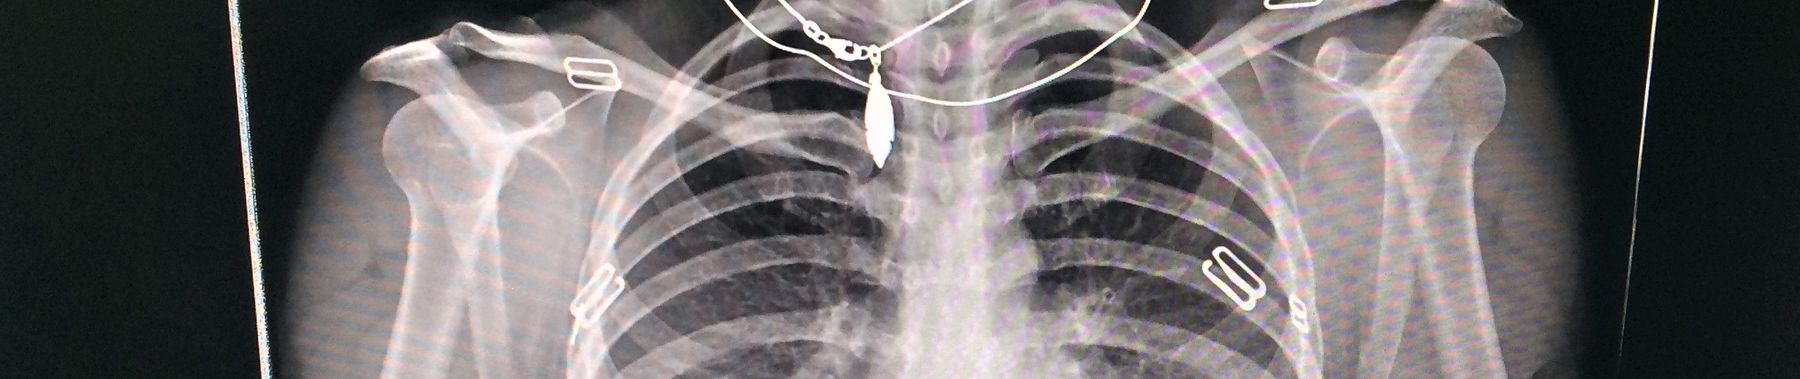

Aluno: Vinícius de Souza Lima

In [68]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from typing import Literal
from PIL import Image
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import math
import fsspec
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FunctionTransformer, Pipeline

## Problema de Classificação (Algoritmos Clássicos)

In [18]:
class Dataset:
    def __init__(
        self,
        name: str,
        path_dir: str,
    ):
        self.name = name
        self.path_dir = path_dir
        self.files = None

    def load_dataset(self):
        dir = Path(self.path_dir)
        files = dir.rglob("*.jpeg")
        self.files = files

    def convert_toarray(
        self,
        target_values: list[str],
        fallback: str | None = None,
        resolution: tuple[int, int] = (128, 128),
    ):
        imgs = []
        targets = []

        for f in self.files:
            if f.is_dir():
                continue

            imgs.append(
                np.array(
                    Image.open(str(f))  # Lê a imagem
                    .convert("L")  # Converte para escala de cinza
                    .resize(
                        resolution, Image.Resampling.LANCZOS
                    )  # Redimensiona a imagem
                ).flatten()  # Formata a matriz como array
            )
            targets.append(
                next(
                    (1 for cat in f.name.split("_") if cat in target_values),
                    fallback,  # procura categoria no nome do arquivo
                )
            )

        return np.stack(imgs), np.array(targets).astype("bool")

    def save_converted(self, X: npt.ArrayLike, y: npt.ArrayLike) -> None:
        def dividir_array(X: npt.NDArray, max_size_mb=24):
            tam_x = X.nbytes
            tam_max = 1024 * 1024 * max_size_mb

            n_elem = math.ceil(tam_x / tam_max)
            return np.array_split(X, n_elem)

        cwd = Path(".")
        (cwd / "datasets").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}" / "X").mkdir(exist_ok=True)
        (cwd / "datasets" / f"{self.name}" / "y").mkdir(exist_ok=True)

        data_path = cwd / "datasets" / f"{self.name}"

        for i, array in enumerate(dividir_array(X)):
            np.save(str(data_path / "X" / f"X_{i}"), array)  # Save x

        for i, array in enumerate(dividir_array(y)):
            np.save(str(data_path / "y" / f"y_{i}"), array)  # Save y

    @staticmethod
    def load_converted(path: str):
        X = []
        y = []
        path_x = Path(path) / "X"
        for file in sorted(path_x.glob("*")):
            X.append(np.load(str(file)))
        X = np.vstack(X)

        path_y = Path(path) / "y"
        for file in sorted(path_y.glob("*")):
            y.append(np.load(str(file)))
        y = np.vstack(y)

        return X, y.astype("bool")

    @staticmethod
    def download_from_remote(
        owner: str,
        repo: str,
        folder: str,
        destination: Path = Path("."),
    ):
        """
        Baixa pasta de repositório remoto do github de forma
        recursiva.
        """
        fs = fsspec.filesystem(protocol="github", org=owner, repo=repo)
        local_dir = destination / folder
        local_dir.mkdir(exist_ok=True, parents=True)
        fs.get(folder, local_dir.as_posix(), recursive=True)

Inicialmente foi usado o código abaixo para baixar o dataset de imagens do repositório do Kaggle

In [50]:
#path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
#path_chest = (
    #Path(
        #"/home/vinicius/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/"
    #)
    #/ "chest_xray"
   # / "chest_xray"
#)
#chest_data = Dataset("chest", path_chest)
#chest_data.load_dataset()
#X_chest, y_chest = chest_data.convert_toarray(["bacteria", "virus"], 0, (128, 128))
#chest_data.save_converted(X_chest, y_chest)

Nos usos subsequentes usou-se o dataset já armazenado no repositório remoto

In [19]:
Dataset.download_from_remote("vinicius-souza-lima", "mvp_ml", "datasets")
X_chest, y_chest = Dataset.load_converted("datasets/chest")

### Definição do Problema

#### Descrição do problema

 Classificar imagem de raio x de paciente em saudável ou com pneumonia utilizando algoritmos de machine learning clássicos. 

#### Premissas ou hipóteses sobre o problema

É assumido que para dada imagem, existem duas possibilidades de classificação em relação a pneumonia:

- `0`: Significa que o paciente não possui pneumonia.
- `1`: Signica que o paciente possui pneumonia causada por bactéria ou virus. 

Foi considerado que seria importante tanto possuir precisão quanto recall elevados, visto que no diagnóstico de pneumonia tanto falsos positivos quanto falsos negativos podem ser altamente prejudiciais ao paciente. Portanto buscou-se métricas que equilibrassem essas duas medidas. 

#### Restrições para selecionar os dados

Os dados selecionados foram provenientes de um dataset já existente hospedado no [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data). Todas as imagens presentes no dataset foram utilizadas, com a classificação retirada do nome fornecido aos arquivos.

#### Descrição do Dataset

O dataset consiste de 5856 imagens de raio-x da região toráxica que foram redimensionadas para a resolução de 128x128 para facilitar o processamento de imagens. A matriz `X` possui todas as imagens no formato de arrays empilhadas verticalmente, enquanto `y` é um vetor binário com as classificações.

In [20]:
X_chest.shape

(5856, 16384)

In [69]:
print(
    f" O dataset consiste de {y_chest.sum()/y_chest.shape[1]*100.0:.2f}% de imagens de pacientes doentes."
)

 O dataset consiste de 72.97% de imagens de pacientes doentes.


Abaixo um exemplo de imagem de de raio X.

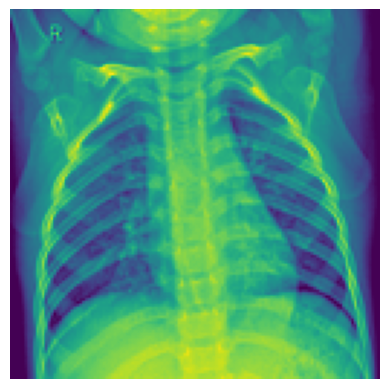

In [ ]:
plt.imshow(X_chest[4000].reshape((128, 128)))
plt.axis("off")
plt.show()

### Preparação dos dados

#### Separação do Dataset em treino e teste

Na separação entre treino e teste foi considerado o desbalanceamento das classes por meio do argumento `stratify`.

In [38]:
X_chest_train, X_chest_test, y_chest_train, y_chest_test = train_test_split(
    X_chest,
    y_chest.reshape((-1, 1)),
    test_size=0.2,
    random_state=42,
    stratify=y_chest.reshape((-1, 1)),
)

num_particoes = 10
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=42)

#### Pré-processamento

In [24]:
pre = Pipeline(
    [
        ("converte_float", FunctionTransformer(lambda X: X.astype("float64"))),
        ("normalizacao", StandardScaler()),
    ]
)

In [25]:
X_chest_train_pre = pre.fit_transform(X_chest_train)

### Modelagem e treinamento

No decorrer das análises foi percebido que os modelos escolhidos com métricas de acurácia tendiam a ter alto número de falsos positivos (paciente saudável rotulado como doente) e baixo número de falsos negativos (paciente doente rotulado como saudável). A métrica que melhor equilibrou FP e FN foi a precisão, sendo esta a métrica escolhida.  

In [26]:
def choose_model(
    scoring: Literal["accuracy", "balanced_accuracy", "f1_macro"] = "accuracy",
    seed: int = 42,
    n_jobs=3,
):
    np.random.seed(seed)
    results = []

    models = {
        "NB": GaussianNB(),  # 5 sec
        "KNN": KNeighborsClassifier(),  # 12 sec
        "RF": RandomForestClassifier(),  # +- 3 min
        "CART": DecisionTreeClassifier(),  # +- 7 min
    }

    for name, model in models.items():
        cv_results = cross_val_score(
            model,
            X_chest_train_pre,
            y_chest_train.ravel(),
            cv=kfold,
            scoring=scoring,
            n_jobs=n_jobs,
        )
        results.append(cv_results)
        print(f"{name}: Média: {cv_results.mean():.3f}, std:{cv_results.std():.3f}")

    return results

In [ ]:
# scoring = "precision"
# results = choose_model(scoring=scoring, seed=42, n_jobs=1)

NB: Média: 0.942, std:0.013
KNN: Média: 0.909, std:0.011
RF: Média: 0.950, std:0.009
CART: Média: 0.909, std:0.010


In [ ]:
# joblib.dump(results,"models/results.npy")
Dataset.download_from_remote("vinicius-souza-lima", "mvp_ml", "models")
results = joblib.load("models/results.npy")

/tmp/ipykernel_237602/2461690942.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names)


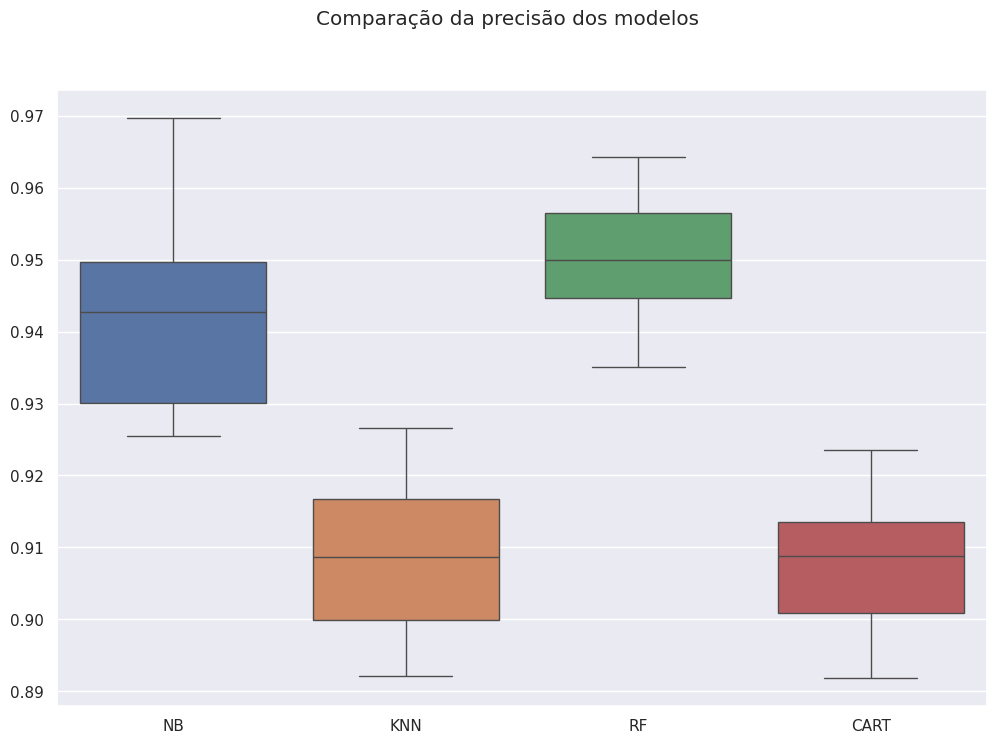

In [46]:
sns.set_theme()
names = ["NB", "KNN", "RF", "CART"]
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Comparação da precisão dos modelos")
ax.set_xticklabels(names)
sns.boxplot(results);

Os reultados do modelo Random Forest tiveram maior mediana e mais consistentemente possuem melhor score. Assim foi escolhido Random Forest para prosseguir na otimização de hiperparâmetros.

#### Otimização de Hiperparâmetros

In [47]:
def otimize_hyper(
    scoring: Literal["accuracy", "balanced_accuracy", "f1_macro"] = "accuracy",
    seed: int = 42,
    n_iter=20,
    n_jobs=3,
    cv=kfold,
    class_weight="balanced",
):
    model = RandomForestClassifier(random_state=seed, class_weight=class_weight)
    param_grid = {
        "n_estimators": [50, 100, 300],
        "max_depth": [None, 2, 5, 10],
        "min_samples_split": [2, 4, 5],
        "min_samples_leaf": [2, 4, 5],
    }

    random_search = RandomizedSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_iter=n_iter,
        n_jobs=n_jobs,
        random_state=seed,
    )
    random_search.fit(X_chest_train_pre, y_chest_train.ravel())
    print(f"O melhor modelo teve parâmetros:{random_search.best_params_}")
    print(f"O melhor score foi:{random_search.best_score_:.2f}")
    return random_search.best_estimator_

In [48]:
# final_clf = otimize_hyper(scoring="precision", class_weight="balanced", n_jobs=2, n_iter=5)

O melhor modelo teve parâmetros:{'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 5}
O melhor score foi:0.96


In [49]:
# joblib.dump(final_clf,"models/final_clf.joblib")
final_clf = joblib.load("models/final_clf.joblib")

In [53]:
final_model = make_pipeline(pre, final_clf)

### Avaliação de Resultados

#### Métricas de Avaliação

In [54]:
y_chest_predict = final_model.predict(X_chest_test)

##### Acurácia

In [55]:
accuracy_score(y_chest_test, y_chest_predict)

0.909556313993174

O modelo apresenta acurácia elevada, ou seja, a proporção de acertos é alta entre todas as previsões.

##### Matriz de confusão

A matriz de confusão abaixo nos permite analisar como se distribuem
as previsões de acordo com o previsto pelo modelo.

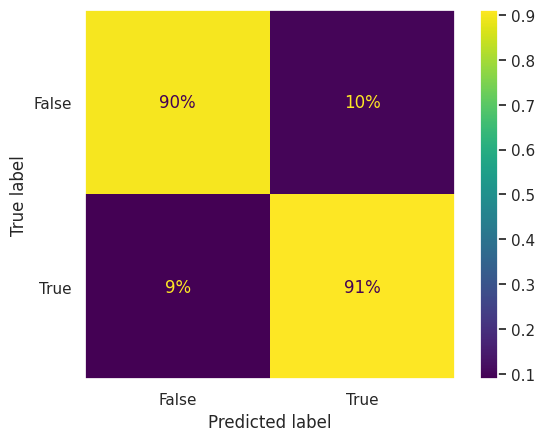

In [56]:
ConfusionMatrixDisplay.from_predictions(
    y_chest_test, y_chest_predict, normalize="true", values_format="0.0%"
)
plt.grid(False)

Percebe-se que o modelo tem desempenho razoável tanto para correta previsão de pneumonia quanto detecção de pacientes saudáveis, errando na previsão em 10% dos pacientes saudáveis e em 9% dos doentes. Dessa forma o modelo demonstra conseguir diferenciar corretamente as classes.

##### Precisão

In [62]:
print("Precisão:", precision_score(y_chest_test, y_chest_predict))

Precisão: 0.9617755856966708


O modelo possui elevada precisão, ou seja, minimiza a quantidade de falsos positivos.

##### Recall

In [63]:
print("Recall:", recall_score(y_chest_test, y_chest_predict))

Recall: 0.9122807017543859


O modelo também possui elevado recall, minimizando assim a quantidade de falsos negativos.

##### Curva ROC

In [59]:
y_chest_pproba = final_model.predict_proba(X_chest_test)

In [60]:
def plot_roc(y_true: npt.ArrayLike, y_score: npt.ArrayLike):
    sns.set_theme()
    _, ax = plt.subplots(figsize=(10, 10))

    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    auc = roc_auc_score(y_true, y_score[:, 1])
    ax.plot(fpr, tpr, lw=2, c="red", label=f"(AUC = {auc:.2f})")

    ax.plot(
        [0, 1], [0, 1], label="Classificador Aleatório (AUC = 0.5)"
    )  # Plota classificador aleatório
    ax.plot(
        [0, 0, 1], [0, 1, 1], label="Classificador Perfeito (AUC = 1.0)"
    )  # Plota classificador perfeito

    ax.grid(True)
    ax.legend()
    plt.show()

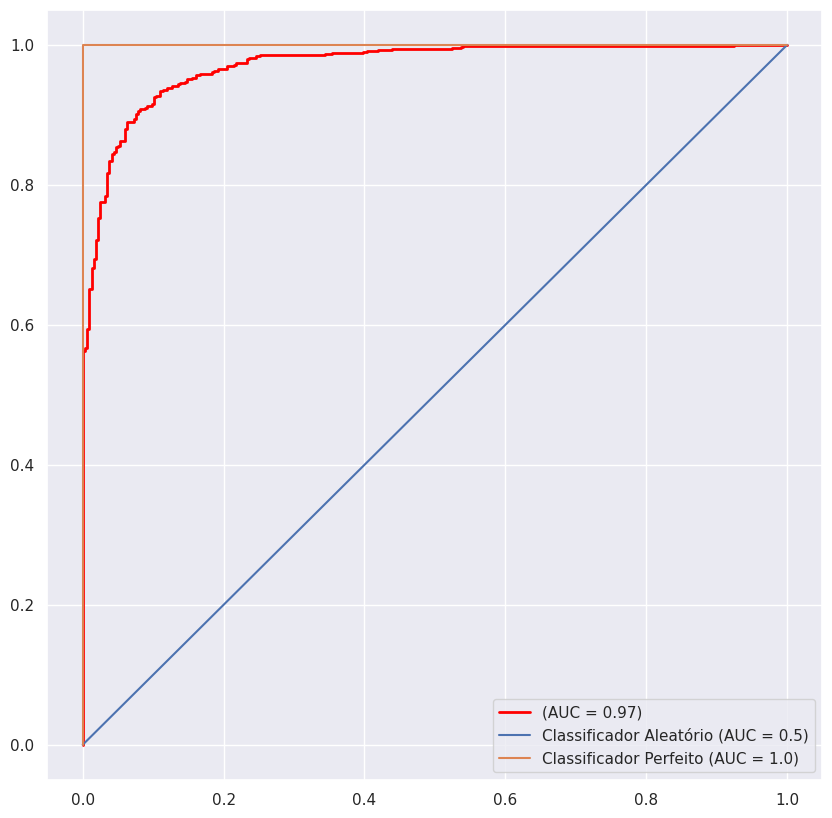

In [61]:
plot_roc(y_chest_test, y_chest_pproba)

Percebe-se que o modelo possui área abaixo da curva próxima de 1, que seria o classificador perfeito, demonstrando alta capacidade de diferenciar entre as classes.